<a href="https://colab.research.google.com/github/ecreager/eiil_dev/blob/public/notebooks/sem_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""Load results from disk. See the run_sems.sh experiment producing results."""
from glob import glob
import os
import pickle
from pprint import pprint

import matplotlib.pyplot as plt

def load_results(dirname):
  return pickle.load(open(os.path.join(dirname, 'metrics.p'), 'rb'))
  
def load_flags(dirname):
  return pickle.load(open(os.path.join(dirname, 'flags.p'), 'rb'))

# ROOT = '/scratch/gobi1/creager/opt_env/run_sems_alpha_sweep/43878915'
ROOT = '/PATH/TO/SWEEP/DIR'

# baselines include HandCrafted->ERM, ICP, IRM, and ERM->EIIL->IRM
BASELINE_GLOB_PATTERN  = '{}/chain_hidden=0_hetero=2_scramble=0/all_solutions.txt'.format(ROOT)  # TODO(): change

ALPHAS = (
  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
)  # NOTE: UDL workshop paper missed two x-tick marks on this plot
from collections import OrderedDict
ALPHA_SWEEP_GLOB_PATTERNS = OrderedDict()
for alpha in ALPHAS:
  ALPHA_SWEEP_GLOB_PATTERNS[alpha] = \
    '{}/chain_hidden=0_hetero=2_scramble=0_alpha_{}/all_solutions.txt'.format(ROOT, str(alpha))  # TODO(): change

def read_lines(results_glob):
  all_lines = []
  for fn in glob(results_glob):
    lines = open(fn, 'r').read().splitlines()
    all_lines.extend(lines)
  return all_lines

def get_results(all_solutions):
    results = {}

    for line in all_solutions:
        words = line.split(" ")
        setup = str(words[0])
        model = str(words[1])
        err_causal = float(words[-2])
        err_noncausal = float(words[-1])

        if setup not in results:
            results[setup] = {}

        if model not in results[setup]:
            results[setup][model] = []

        results[setup][model].append([err_causal, err_noncausal])
    return results

results_lines = dict()
results_lines['baselines'] = read_lines(BASELINE_GLOB_PATTERN)
results_lines['alpha_sweep'] = OrderedDict()
for a, agp in ALPHA_SWEEP_GLOB_PATTERNS.items():
  results_lines['alpha_sweep'][a] = read_lines(agp)

SETTING = 'chain_hidden=0_hetero=2_scramble=0'  # apply filter to yield only this data setting
# results = {k: get_results(rl)[SETTING] for k, rl in results_lines.items()}
results = dict()
results['baselines'] = get_results(results_lines['baselines'])[SETTING]
results['alpha_sweep'] = OrderedDict()
for a in ALPHAS:
  results['alpha_sweep'][a] = get_results(results_lines['alpha_sweep'][a])[SETTING]

from pprint import pprint
pprint(results)
for a in ALPHAS:
  print(a, results['alpha_sweep'][a])

{'alpha_sweep': OrderedDict([(0.1,
                              {'EIIL': [[1.20987, 1.08879],
                                        [1.03908, 0.92657],
                                        [1.27709, 1.12844],
                                        [1.56064, 1.35345],
                                        [0.58332, 0.56332]],
                               'SEM': [[0.0, 0.0],
                                       [0.0, 0.0],
                                       [0.0, 0.0],
                                       [0.0, 0.0],
                                       [0.0, 0.0]]}),
                             (0.2,
                              {'EIIL': [[0.58675, 0.56536],
                                        [0.42208, 0.41769],
                                        [0.47998, 0.46702],
                                        [0.49813, 0.49398],
                                        [0.47181, 0.47596]],
                               'SEM': [[0.0, 0.0],
                   

In [ ]:
"""Produce table from baseline errors."""
from collections import defaultdict
import numpy as np
import pandas as pd

LATEX_SYMBOLS = dict(
    ERM=r'\textsc{ERM}',
    ICP=r'\textsc{ICP}',
    IRM=r'\textsc{IRM}($e_{\textsc{HC}}$)',
    EIIL=r'\textsc{IRM}($e_{\textsc{EIIL}}| \tilde \Phi = \Phi_{ERM}$)',
    alpha=r'\textsc{IRM}($e_{\textsc{EIIL}}| \tilde \Phi = \Phi_{\alpha-Spurious}$)',
)

baseline_errors = defaultdict(dict)
for method, v in results['baselines'].items():
  if method == 'SEM':
    continue
  results_ = np.stack(v)
  mean = np.mean(results_, 0)
  std = np.std(results_, 0)
  baseline_errors['Causal err.'][LATEX_SYMBOLS[method]] = (mean[0], std[0])
  baseline_errors['Noncausal err.'][LATEX_SYMBOLS[method]] = (mean[1], std[1])

def f(xy):
  """Format mean plus/minus std dev."""
  x, y = xy
  return r"""%.3f $\pm$ %.3f""" % (x, y)

re = pd.DataFrame.from_dict(baseline_errors)
results_tex = re.to_latex(
  formatters=[f, ] * len(re.T),
  escape=False,
  caption=(
      'Results on synthetic data. MSE on causal and non-causal portions of the '
      'ground truth regression coefficient are reported, plus/minus a standard '
      'deviation across ten runs. '
  )
)
print(results_tex)

\begin{table}
\centering
\caption{Results on synthetic data. MSE on causal and non-causal portions of the ground truth regression coefficient are reported, plus/minus a standard deviation across ten runs. }
\begin{tabular}{lll}
\toprule
{} &        Causal err. &     Noncausal err. \\
\midrule
\textsc{IRM}($e_{\textsc{EIIL}}| \tilde \Phi = ... &  0.148 $\pm$ 0.186 &  0.145 $\pm$ 0.177 \\
\textsc{ERM}                                       &  0.827 $\pm$ 0.014 &  0.824 $\pm$ 0.013 \\
\textsc{ICP}                                       &  1.000 $\pm$ 0.000 &  0.756 $\pm$ 0.378 \\
\textsc{IRM}($e_{\textsc{HC}}$)                    &  0.666 $\pm$ 0.073 &  0.644 $\pm$ 0.061 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
"""Aggregate error measurements."""

alpha_sweep_errors = dict()
for k in ('Causal err.', 'Noncausal err.'):
  alpha_sweep_errors[k] = defaultdict(list)

for a, v in results['alpha_sweep'].items():
  v = v['EIIL']
  results_ = np.stack(v)
  mean = np.mean(results_, 0)
  std = np.std(results_, 0)
  alpha_sweep_errors['Causal err.']['mean'].append(mean[0])
  alpha_sweep_errors['Causal err.']['upper'].append(mean[0] + std[0])
  alpha_sweep_errors['Causal err.']['lower'].append(mean[0] - std[0])
  alpha_sweep_errors['Noncausal err.']['mean'].append(mean[1])
  alpha_sweep_errors['Noncausal err.']['upper'].append(mean[1] + std[1])
  alpha_sweep_errors['Noncausal err.']['lower'].append(mean[1] - std[1])

pprint(alpha_sweep_errors)


{'Causal err.': defaultdict(<class 'list'>,
                            {'lower': [0.8113512859470844,
                                       0.4379805852737823,
                                       0.3724721939410729,
                                       0.4618428616988267,
                                       0.4744283322088388,
                                       0.4980206186699855,
                                       0.263303767349623,
                                       0.26781109357941757,
                                       0.0003069626691261096,
                                       -0.03410407140531893],
                             'mean': [1.134,
                                      0.49175,
                                      0.629148,
                                      0.678092,
                                      0.8229799999999999,
                                      0.889932,
                                      0.41328,
                   

{0: <__main__.LegendObject object at 0x7f59bab72f98>}
{0: <__main__.LegendObject object at 0x7f59bab72f98>, 1: <__main__.LegendObject object at 0x7f59bab51898>}
{0: <__main__.LegendObject object at 0x7f59bab72f98>, 1: <__main__.LegendObject object at 0x7f59bab51898>, 2: <__main__.LegendObject object at 0x7f59bab51ef0>}
{0: <__main__.LegendObject object at 0x7f59bab72f98>, 1: <__main__.LegendObject object at 0x7f59bab51898>, 2: <__main__.LegendObject object at 0x7f59bab51ef0>, 3: <__main__.LegendObject object at 0x7f59b8aeb550>}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


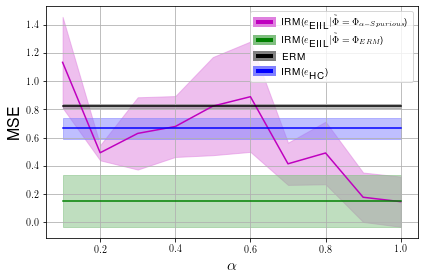

{0: <__main__.LegendObject object at 0x7f5a0dfa3fd0>}
{0: <__main__.LegendObject object at 0x7f5a0dfa3fd0>, 1: <__main__.LegendObject object at 0x7f5a0cebfa58>}
{0: <__main__.LegendObject object at 0x7f5a0dfa3fd0>, 1: <__main__.LegendObject object at 0x7f5a0cebfa58>, 2: <__main__.LegendObject object at 0x7f5a0cecd080>}
{0: <__main__.LegendObject object at 0x7f5a0dfa3fd0>, 1: <__main__.LegendObject object at 0x7f5a0cebfa58>, 2: <__main__.LegendObject object at 0x7f5a0cecd080>, 3: <__main__.LegendObject object at 0x7f5a0cecd668>}


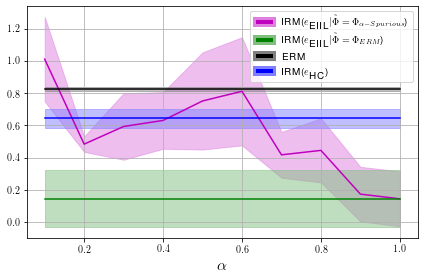

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
import seaborn as sns

TITLE_FONTSIZE = 16
AXIS_FONTSIZE = 16
LEGEND_FONTSIZE = 10
FIGSIZE = (6, 4)
SHADING_OPACITY = .5  # how opaque should the uncertainty fills be


class LegendObject(object):
    def __init__(self, facecolor='red', edgecolor='white', dashed=False):
        self.facecolor = facecolor
        self.edgecolor = edgecolor
        self.dashed = dashed
 
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            # create a rectangle that is filled with color
            [x0, y0], width, height, facecolor=self.facecolor,
            # and whose edges are the faded color
            edgecolor=self.edgecolor, lw=3)
        handlebox.add_artist(patch)
 
        # if we're creating the legend for a dashed line,
        # manually add the dash in to our rectangle
        if self.dashed:
            patch1 = mpatches.Rectangle(
                [x0 + 2*width/5, y0], width/5, height, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)
 
        return patch
 
 
def plot_mean_and_CI(x_axis_vec, mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(x_axis_vec, ub, lb,
                     color=color_shading, alpha=.5)
    # plt.fill_between(range(mean.shape[0]), ub, lb,
    #                  color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(x_axis_vec, mean, color=color_mean)
 
# plot the data
a = lambda x: np.array(x)
bg = np.array([1, 1, 1])  # background of the legend is white
for metric in ('Causal err.', 'Noncausal err.'):
  from itertools import cycle
  handler_map = dict()
  colors = iter('mgkb')
  legend_names = []
  plt.figure(figsize=FIGSIZE)
  color = next(colors)
  color_faded = (np.array(cc.to_rgb(color)) + bg) * SHADING_OPACITY
  handler_map[len(legend_names)] = LegendObject(color, color_faded)
  print(handler_map)
  legend_names.append(LATEX_SYMBOLS['alpha'])
  a = lambda x: np.array(x)
  plot_mean_and_CI(ALPHAS,
                  a(alpha_sweep_errors[metric]['mean']),
                  a(alpha_sweep_errors[metric]['lower']),
                  a(alpha_sweep_errors[metric]['upper']),
                  color_mean=color, color_shading=color_faded)
 
  for m, v in baseline_errors[metric].items():
    if m == LATEX_SYMBOLS['ICP']:  # don't plot this baseline b/c it doesn't work anyways
      continue
    color = next(colors)
    color_faded = (np.array(cc.to_rgb(color)) + bg) * SHADING_OPACITY
    handler_map[len(legend_names)] = LegendObject(color, color_faded)
    print(handler_map)
    legend_names.append(m)
    mean = v[0] * np.ones(len(ALPHAS))
    upper = (v[0] + v[1]) * np.ones(len(ALPHAS))
    lower = (v[0] - v[1]) * np.ones(len(ALPHAS))
    plot_mean_and_CI(ALPHAS,
                    mean,
                    lower,
                    upper,
                    color_mean=color, color_shading=color_faded)
  plt.legend(range(len(legend_names)), legend_names, handler_map=handler_map,
             loc='upper right', fontsize=LEGEND_FONTSIZE)
  plt.xlabel(r'$\alpha$', fontsize=AXIS_FONTSIZE)
  if metric == 'Causal err.':
    plt.ylabel('MSE', fontsize=AXIS_FONTSIZE)
  # plt.title(metric, fontsize=TITLE_FONTSIZE)
  plt.tight_layout()
  plt.grid()
  plt.show()